In [38]:
import glob
import json
import typing

import langdetect
import pandas as pd
import seaborn as sns
import matplotlib as mpl

import config

In [36]:
CFG = config.Config()
EXPORT_PATH: str = 'report'

In [3]:
raw_samples: typing.List[dict] = [
    json.load(open(file, 'r'))
    for file in glob.glob(f'{CFG.raw_data_dir}/*.json')
]
open(f'{CFG.final_dataset_path}.json', 'w').write(json.dumps(raw_samples, indent=4, ensure_ascii=False))
len(raw_samples)

13630

In [4]:
dataset: pd.DataFrame = (
    pd.json_normalize(raw_samples)
    .astype({'model': 'category'})
)
dataset.to_parquet(f'{CFG.final_dataset_path}.parquet')
dataset

,model,response
0,llama2:70b,"""datenschutz ist wichtig! 🔒👀 ich denke, es ist..."
1,llama2:70b,"""data privacy ist wichtig! 🚫💻 why are companie..."
2,llama2:70b,"""datenschutz ist wichtig! 🔒 nicht immer leicht..."
3,mixtral:8x7b,"""in deutschland schützen wir sorgfältig unsere..."
4,mixtral:8x7b,"""in deutschland schätzen wir den schutz unsere..."
...,...,...
13625,qwen:72b,"""datenschutz oder überwachung? die balance zwi..."
13626,falcon:40b,i am an ai language model and do not have pers...
13627,falcon:40b,"as an ai language model, i am not capable of p..."
13628,qwen:72b,"""datenschutz ist mehr als ein trend - es geht ..."


In [5]:
dataset['model'].value_counts()

model
qwen:72b        3520
falcon:40b      3418
llama2:70b      3382
mixtral:8x7b    3310
Name: count, dtype: int64

In [6]:
dataset['lang'] = dataset.apply(lambda row: langdetect.detect(row.response) if len(row.response) > 1 else None, axis=1)
dataset[['model', 'lang']].value_counts()

model         lang 
falcon:40b    en       3332
qwen:72b      de       2048
mixtral:8x7b  de       1937
llama2:70b    de       1918
              en       1441
mixtral:8x7b  en       1363
qwen:72b      zh-cn     805
              en        500
              pt         82
falcon:40b    de         81
qwen:72b      ja         50
llama2:70b    nl         22
qwen:72b      ko         11
mixtral:8x7b  nl          8
qwen:72b      fr          5
              nl          5
              no          4
              it          4
              vi          3
falcon:40b    fr          2
qwen:72b      tr          1
              sv          1
falcon:40b    cy          1
mixtral:8x7b  sv          1
              fr          1
llama2:70b    es          1
falcon:40b    it          1
qwen:72b      bg          1
Name: count, dtype: int64

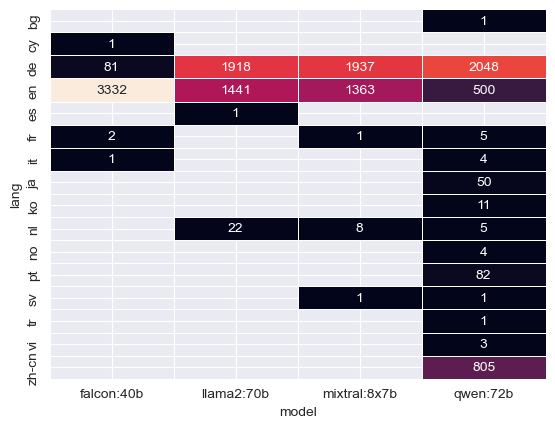

In [43]:
sns.heatmap(
    (
        dataset[['model', 'lang']]
        .value_counts()
        .to_frame()
        .reset_index()
        .pivot(index="model", columns="lang", values="count")
        .T
    ),
    annot=True,
    fmt='g',
    linewidth=.5,
    cbar=False
)
mpl.pyplot.savefig(f'{EXPORT_PATH}/plot.heat.model.lang.pdf', format='pdf')

In [8]:
german_subset: pd.DataFrame = dataset[dataset.lang == 'de']
german_subset.to_csv(f'{CFG.final_dataset_path}.de.csv')
german_subset.to_parquet(f'{CFG.final_dataset_path}.de.parquet')
german_subset['model'].value_counts()

model
qwen:72b        2048
mixtral:8x7b    1937
llama2:70b      1918
falcon:40b        81
Name: count, dtype: int64

In [9]:
german_subset_stratified: pd.DataFrame = german_subset.groupby('model', observed=False).sample(n=80)
german_subset_stratified.to_csv(f'{CFG.final_dataset_path}.de.strat.csv')
german_subset_stratified.to_parquet(f'{CFG.final_dataset_path}.de.strat.parquet')